In [1]:
import cdms
import numpy as np
import matplotlib.pyplot as plt
import pandas
%matplotlib inline

# plot raw pulse
from rawio.IO import *

In [2]:
filepath = '/sdf/home/y/yanliu/data/mckay/debug20230622/'
#traces = getRawEvents(filepath, '23230510_172313_F0018.mid.gz')# 30V
traces = getRawEvents(filepath, '51230512_000000_F0027.mid.gz')# 30V test signal
#traces = getRawEvents(filepath, '23230511_003046_F0015.mid.gz')# 10 V
#traces = getRawEvents(filepath, '23230511_032625_F0022.mid.gz')# 0V

chan_names = ['PAS1', 'PBS1', 'PCS1', 'PDS1', 'PES1', 'PFS1', 'PAS2', 'PBS2', 'PCS2', 'PDS2', 'PES2', 'PFS2']

seriesNumber = 51230512000000

The file is: /sdf/home/y/yanliu/data/mckay/debug20230622//51230512_000000_F0027.mid.gz

Opened raw midas file: /sdf/home/y/yanliu/data/mckay/debug20230622//51230512_000000_F0027.mid.gz
The file is: /sdf/home/y/yanliu/data/mckay/debug20230622//51230512_000000_F0027.mid.gz

Opened raw midas file: /sdf/home/y/yanliu/data/mckay/debug20230622//51230512_000000_F0027.mid.gz


In [3]:
#print(traces['Z7']['PBS1'][seriesNumber][270000][0:1000])

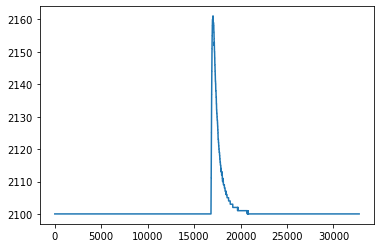

In [6]:
plt.plot(traces['Z7']['PBS1'][seriesNumber][270000][:])

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


In [25]:
def low_pass_filter(data, alpha):
    """
    Applies a simple low-pass filter to a data series.

    :param data: a list or array of numeric data
    :param alpha: a smoothing factor between 0 and 1
    :return: a list containing the filtered data
    """
    filtered = [data[0]]  # initialize the filtered data with the first value of the input
    for i in range(1, len(data)):
        filtered.append(alpha * data[i] + (1 - alpha) * filtered[-1])
    return filtered

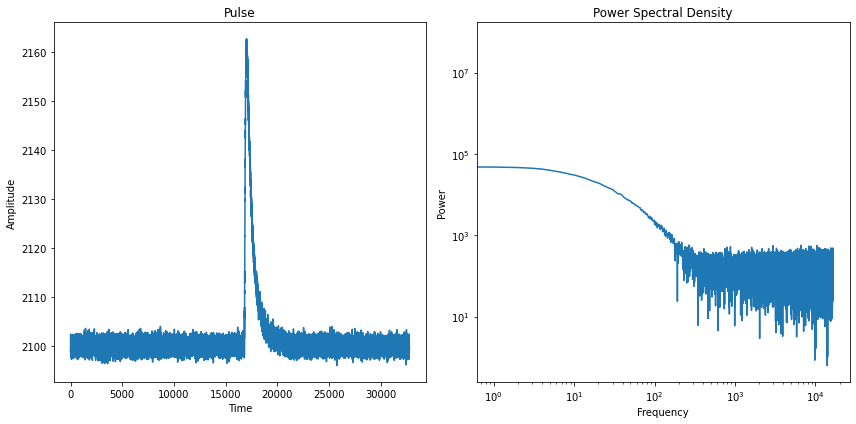

In [58]:
tracelength = 32768
t = np.arange(tracelength)
#pulse = traces['Z7']['PBS1'][seriesNumber][270000]
#pulse = np.random.normal(0, 1, tracelength)
pulse = traces['Z7']['PBS1'][seriesNumber][270000] + 1*np.random.normal(0, 1, tracelength)

# Calculate the FFT
fft = np.fft.rfft(pulse)

# Calculate the PSD
psd = np.abs(fft) # A/sqrt(Hz)


# Plotting the results
plt.figure(figsize=(12, 6))

# Plot the pulse
plt.subplot(1, 2, 1)
plt.plot(t, pulse)
#plt.plot(t, low_pass_filter(pulse, 0.01))
plt.title('Pulse')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot the PSD
plt.subplot(1, 2, 2)
plt.plot(psd)
plt.title('Power Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.xscale('log')
plt.yscale('log')


plt.tight_layout()
plt.show()

In [62]:
fft

array([ 6.88610946e+07    +0.j        , -4.66106673e+04+10686.95415276j,
        4.19547571e+04-19972.14074682j, ...,
       -2.37498423e+02   +52.96651085j, -2.94869654e+01  -106.96562774j,
       -4.75525370e+02    +0.j        ])

Reproduce time-domain noise

In [66]:
test = np.fft.irfft(fft)

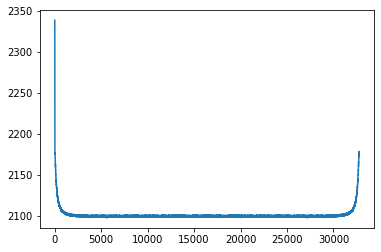

In [67]:
plt.plot(test)
#plt.xscale('log')
#plt.yscale('log')

In [46]:
def add_rand_to_psd(psd_vector, noise_amplitude):
    noise = np.random.normal(0, noise_amplitude, len(psd_vector))
    noisy_psd = psd_vector + noise
    return noisy_psd

In [51]:
psd_gen = add_rand_to_psd(psd, 1e4)

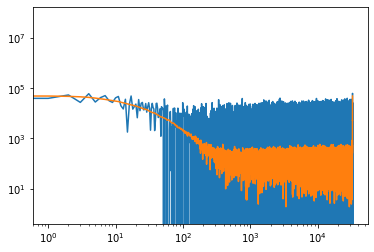

In [52]:
plt.plot(psd_gen)
plt.plot(psd)
plt.xscale('log')
plt.yscale('log')

In [53]:
def psd_to_time_domain(psd_vector):
    
    # Convert psd to A^2/Hz
    psd_vector = psd_vector ** 2
    
    # Calculate the complex conjugate of the PSD
    #psd_conjugate = np.conjugate(psd_vector)

    # Combine the PSD vector with its complex conjugate
    #psd_combined = np.concatenate((psd_vector, psd_conjugate[1:-1][::-1]))

    # Perform inverse Fourier Transform
    time_signal = np.fft.ifft(psd_vector)
    #time_signal = np.fft.ifft(psd_combined)

    return time_signal

In [54]:
test = psd_to_time_domain(psd)

/sdf/home/y/yanliu/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


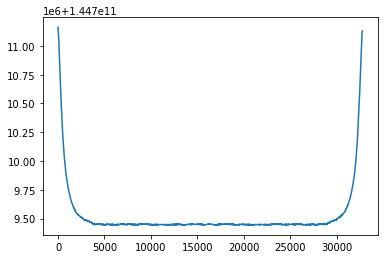

In [55]:
plt.plot(test)

In [41]:
def PSD_noise(PSD, odd=False, N=1):
    edit_PSD = np.copy(PSD)
    edit_PSD[0] *= 2
    if odd:
        n = (len(PSD)-1)*2 + 1
    else:
        edit_PSD[-1] *= 2
    n = (len(PSD)-1)*2
     
    ampls = np.sum(np.array([1,1j]) * np.random.randn(len(PSD), N, 2), axis=-1)
     
    return np.fft.irfft(np.sqrt(edit_PSD/2)[:,np.newaxis] * ampls, axis=0, n=n).squeeze()

In [43]:
noise = PSD_noise(psd)
plt.plot(noise)
plt.plot(low_pass_filter(noise, 0.001))